<h1> BBHs merging catalog generator </h1> 

In the following, we'll implement a notebook that, given a certain volume of sky, will return a catalog of possible BBHs merging events.
The probability distribution implemented for the variables of the events, will be taken from [B. P. Abbott](https://arxiv.org/abs/1811.12940).
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
import multiprocessing as mp
from multiprocessing import Pool, Manager
from functools import partial
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

Let's start by defining the probability distribution in function of the masses, we'll assume that the regime $m_{min} \leq m_{2} \leq m_{1} \leq m_{max}$ holds, hence the density distribution will represent the probability of having one BH in the mass range and the other with mass lower to the first one.
Due to the simmetry of the problem, the total number of events should be multiplied by 2.
We have :

In [2]:
# Function for estimating the Phase Space costant of the Mass distribution

def MassPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q):
    
    ris = 0.
    
    for i in range(len(ran_m1)- 1):
        for j in range(len(ran_m2)- 1):
            if(ran_m1[i] >= m_min and ran_m1[i] <= m_max and ran_m2[j] <= ran_m1[i] and ran_m2[j] >= m_min):
                mid_m1 = 0.5*(ran_m1[i + 1] + ran_m1[i])
                mid_m2 = 0.5*(ran_m2[j + 1] + ran_m2[j])
                q = mid_m2/mid_m1 
                ris +=  (ran_m1[i + 1] - ran_m1[i])*(ran_m2[j + 1] - ran_m2[j])*(np.power(mid_m1, (-alpha))*np.power(q, beta_q))
   
    return ris

In [3]:
# Function for the distribution in function of mass

def MassDistr(m1, m2, m_min, m_max, alpha, beta_q, C_norm):
    if(m1 >= m_min and m1 <= m_max and m2 <= m1 and m2 >= m_min) :
        q = m2/m1
        return (C_norm*np.power(m1, (-alpha))*np.power(q, beta_q))
    else :
        return 0.

Then, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [4]:
# Just a function to convert from Z to GPC using Hubble Law

def Z_to_Gpc(z):
    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 1

and the function that estimates the differential comoving volume in function of the redshift :

In [5]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z):
    r = Z_to_Gpc(z)    
    return (4.*np.pi*(r**2.))

Now let's define the auxiliary functions for the spin distribution density :

In [6]:
def BetaSpinParameters(Expected_a, Var_a):
    expec_rel = (Expected_a/(1. - Expected_a))
    beta_a = ((expec_rel - Var_a*np.power(1. + expec_rel, 2.))/(Var_a*np.power(1. + expec_rel, 3.)))
    alpha_a = expec_rel*beta_a
    return alpha_a, beta_a

and hence, the spin distribution module density is given by :

In [7]:
# Estimating the beta function, that will be used as a normalization constant, by using the trapeze method to avoid problems in the extremes

def Beta_Func(span_a, alpha_a, beta_a):
    ris = 0.
    for i in range(len(span_a)- 1):
        mid_a = 0.5*(span_a[i + 1] + span_a[i])
        ris +=  (span_a[i + 1] - span_a[i])*(np.power(mid_a,(alpha_a - 1.))*np.power((1. - mid_a),(beta_a - 1.)))
   
    return ris

In [8]:
# Distribution for the spin amplitude, the beta distribution could get values bigger than 1 !

def SpinModDistrib(a, alpha_a, beta_a, Beta_Val):
     
    return ((np.power(a, alpha_a - 1.)*np.power(1. - a, beta_a - 1.))/(Beta_Val))

while the spin orientations distribution is given by :

In [9]:
# Spin orientation distribution, zeta = 1 gives a gaussian distribution centered in cos_ti = 1, zeta = 0 will return a isotropic distribution

def SpinOrientDistrib(cos_t1,cos_t2, zeta, sigma_1, sigma_2):
    prob = (1. - zeta)/(4) + ((2.*zeta)/(np.pi))*\
    (np.exp(-((np.power(1. - cos_t1,2.))/(2.*np.power(sigma_1,2.))))/(sigma_1*sc.erf(np.sqrt(2)/sigma_1)))\
    *(np.exp(-((np.power(1. - cos_t2,2.))/(2.*np.power(sigma_2,2.))))/(sigma_2*sc.erf(np.sqrt(2)/sigma_2)))
    return prob


We may finally define the distribution function for the number of events :

In [10]:
# Density function for the events in function of the parameters

def NDistrib(z,m1,m2,a_1,a_2,cos_t1,cos_t2):
    n = R_0*DeVC(z)*(T_tot /(1. + z)) \
    *MassDistr(m1,m2, m_min, m_max, alpha,beta_q, (1./MassPhaseSpace)) \
    *SpinModDistrib(a_1, alpha_a, beta_a, BetaVal)*SpinModDistrib(a_2, alpha_a, beta_a, BetaVal) \
    *SpinOrientDistrib(cos_t1, cos_t2, zeta, sigma_1, sigma_2)
    return n

a function to roughly estimate the initial orbital frequency of the event given the massess and the residual coalescence time, as taken by **equation 11 a)** of [S. Marsat and J. G. Baker](https://arxiv.org/pdf/1806.10734.pdf); from that equation we may also estimate the residual time for the events frequency to go outside of the LISA band :

In [11]:
#This function given the mass of the two events and the residual time to coalescence, return the initial frequency of the event at the LISA detection time
def GetInitialFrequency(m1,m2,coal_T):
    M = m1 + m2
    ni = (m1*m2)/(M*M)
    res = ((256.*ni)/(5.*np.power((c*(10.**3.)),5.)))*np.power((G*M*sol_mass),(5./3.))*coal_T
    return (np.power(res,(-(3./8.)))/np.pi)

In [12]:
#This function given the mass of the two events and the max frequency detectable, return the residual time that the event will spend on the Lisa band
def TimeOutFrqRange(m1,m2,f_max):
    M = m1 + m2
    ni = (m1*m2)/(M*M)
    res = (5.*np.power((c*(10.**3.)),5.))/(256.*ni*np.power((np.pi*f_max),(8./3.))*np.power((G*M*sol_mass),(5./3.)))
    return res/year

and some other functions just to make the result appear sexier :

In [13]:
# This function will generate a fake name for the event in the time range of the LISA mission, it will not generate events in the day 29,30,31

def Gen_Event_name():
    
    month = random.randrange(12) + 1
    day = random.randrange(28) + 1
    nid = str(random.randrange(1000) + 1)
    
    if month < 10 :
        month = '0'+ str(month)        
    else:
        month = str(month)
        
    if day < 10 :
        day = '0'+ str(day)        
    else:
        day = str(day)    
        
    return "GW"+ str(random.randrange(34,37))+ month + day +"NId"+ nid


In [14]:
# Generate a number of events equal to the lenght of the array N_EvXBin, with random values in the phase deltavolume for each of the parameter

def Gen_Events_Parameters(d,idx_m1, idx_m2, idx_z, idx_a1, idx_a2, idx_ct1, idx_ct2, N_EvXBin) :
                                
        ev_m1 = random.uniform(ran_m1[idx_m1],ran_m1[idx_m1 + 1])
        ev_m2 = random.uniform(ran_m2[idx_m2],ran_m2[idx_m2 + 1])
        if(ev_m2 > ev_m1):
            app = ev_m1
            ev_m1 = ev_m2
            ev_m2 = app
        ev_ttilde = random.uniform(0., max_tc)                            
        ev_ifrq = GetInitialFrequency(ev_m1,ev_m2,ev_ttilde*year)
        
        # If the event frequency is within the LISA band the others parameters would be generated, in the other case the event is rejected 
        
        if(ev_ifrq <= frq_max):
            ev_ttmaxfr = ev_ttilde -TimeOutFrqRange(ev_m1, ev_m2, frq_max)
            ev_z = random.uniform(ran_z[idx_z],ran_z[idx_z + 1])
            ev_dst = Z_to_Gpc(ev_z)
            ev_inphase = random.uniform(0., 2.*np.pi)
            ev_long = random.uniform(-(0.5*np.pi),0.5*np.pi)
            ev_lat = random.uniform(0.,2.*np.pi)
            ev_inc = random.uniform(0., np.pi) 
            ev_nm = Gen_Event_name()
            ev_sa1 = random.uniform(ran_a_1[idx_a1],ran_a_1[idx_a1 + 1])
            ev_sa2 = random.uniform(ran_a_2[idx_a2],ran_a_2[idx_a2 + 1])
            ev_st1 = np.arccos(random.uniform(ran_cos_t1[idx_ct1],ran_cos_t1[idx_ct1 + 1]))
            ev_st2 = np.arccos(random.uniform(ran_cos_t2[idx_ct2],ran_cos_t2[idx_ct2 + 1]))
            ev_plrz = random.uniform(0., 2.*np.pi)
            
            # Appending the generated event to the catalogue
            
            BH = pd.DataFrame([[ev_nm, ev_z, ev_m1, ev_m2, ev_ifrq, ev_ttmaxfr, ev_long, ev_lat, ev_inc, ev_plrz, ev_inphase, ev_ttilde, ev_dst, ev_sa1, ev_sa2, ev_st1, ev_st2],],\
                                columns = ['EventName', 'Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'OutOfBandTime', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])
            d.append(BH)
                              

The global variables of the simulation will be set to :

In [15]:
# Flags for the execution modes

mode_ex = False
mode_fastmc = False

# Flag for the random seed selection

sel_rs = False

# Number of jobs spawned by the multiprocessing part of the program (use 9/10 * number of core to avoid problems)

n_jobs = (mp.cpu_count() - 4)

# Mass Distribution parameters (values taken from the results of arxiv 1811.12940)

m_min = 5. # Solar Masses
m_max = 50. # Solar Masses
alpha = 1.6 # +-1.6 Big Error !
beta_q = 6.7 # +4.8 -5.9 Still Big Error !

#Spin Amplitude Distribution parameter (values assumed considering the results of  arxiv 1811.12940)

Expected_a = 0.2 # Expected value for the spin amplitude a, < 0.5 with 90% confidence 
Var_a = 1./40.  # Need to setup this value to obtain alpha_a and beta_a >=1
a_max = 1.
alpha_a, beta_a = BetaSpinParameters(Expected_a, Var_a)

#Spin tilt Distribution parameters

sigma_1 = 5.
sigma_2 = 5.
zeta = 1. # For a gaussian distribution of the spin alignment 

# Merger distribution parameters

T_obs = 3. # Lisa estimated years of observation
max_tc = 1000. # max years of coalescence time for a BBH mergine event 
R_0 = 53.2 # +58.5 - 27.0 Gpc^-3 yr-1 Merger rate density assumed constant over the comoving volume
zmax = 0.5 # z value corrispondent to 2 gigaparsec
frq_max = 0.1 # Maximum frequency in hertz to which the LISA detector is sensitive 

#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
H_0 = 67.8 # Hubble constant in Km/(s*MPc)
year = 365.25*24*60*60 # Years in second 

if(alpha_a <=1 or beta_a <=1):
    print('Error in the selection of the values for E[a] and Var[a]')

Let's plot the colormaps of the probability functions to check how they behave :

The integrated probability for all possible mass pairs is :  0.9999999999999982


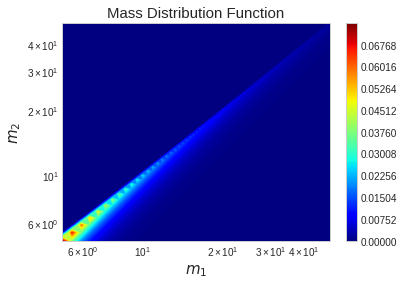

In [16]:
# Colormap of the mass distribution function

Z = np.zeros((100,100))
ran_m1 = np.linspace(m_min,m_max,100)
ran_m2 = np.linspace(m_min,m_max,100)
MassPhaseSpace = MassPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q)
X, Y = np.meshgrid(ran_m1, ran_m2)

for i in range(len(ran_m1)):
    for j in range(len(ran_m2)):
        Z[j][i] = MassDistr(X[j][i], Y[j][i], m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))
        
plt.contourf(X, Y, Z, 1000, cmap='jet')
plt.colorbar();
plt.xlabel(r'$m_1$', fontsize = 15)
plt.ylabel(r'$m_2$', fontsize = 15)
plt.title('Mass Distribution Function', fontsize = 15)
plt.loglog()
plt.savefig('MassDistrib.png',dpi=500)

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_m1)-1):
    for j in range(len(ran_m2)-1):
        totprob += (ran_m1[i + 1] - ran_m1[i])*(ran_m2[j + 1] - ran_m2[j])*MassDistr(st.mean([ran_m1[i],ran_m1[i+1]]), st.mean([ran_m2[j],ran_m2[j+1]]), m_min, m_max, alpha, beta_q, (1./MassPhaseSpace))

print('The integrated probability for all possible mass pairs is : ', totprob) 

The integrated probability for all possible spin amplitudes is :  1.0000000000000007


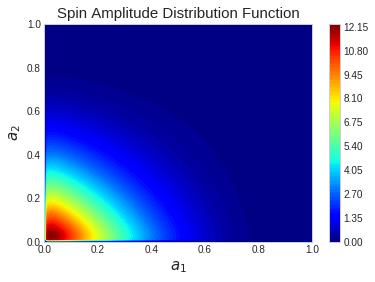

In [17]:
# Colormap of the spin amplitude distribution function

Z = np.zeros((100,100))
ran_a1 = np.linspace(0.,a_max,100)
ran_a2 = np.linspace(0.,a_max,100)
BetaVal = Beta_Func(ran_a1, alpha_a, beta_a)
X, Y = np.meshgrid(ran_a1, ran_a2)

for i in range(len(ran_a1)):
    for j in range(len(ran_a2)):
        Z[j][i] = SpinModDistrib(X[j][i], alpha_a, beta_a, BetaVal)*SpinModDistrib(Y[j][i], alpha_a, beta_a, BetaVal)
        
plt.contourf(X, Y, Z, 100, cmap='jet')
plt.colorbar();
plt.xlabel(r'$a_1$', fontsize = 15)
plt.ylabel(r'$a_2$', fontsize = 15)
plt.title('Spin Amplitude Distribution Function', fontsize = 15)
plt.savefig('SpinAmpDistrib.png',dpi=500)

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_a1)-1):
    for j in range(len(ran_a2)-1):
        totprob += (ran_a1[i + 1] - ran_a1[i])*(ran_a2[j + 1] - ran_a2[j])*SpinModDistrib(st.mean([ran_a1[i],ran_a1[i+1]]), alpha_a, beta_a, BetaVal)*SpinModDistrib(st.mean([ran_a2[j],ran_a2[j+1]]), alpha_a, beta_a, BetaVal)

print('The integrated probability for all possible spin amplitudes is : ', totprob)        

The integrated probability for all possible tilt angles is :  1.0000012893885282


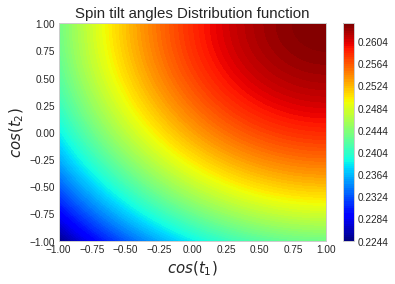

In [18]:
# Colormap of the spin tilt distribution function

Z = np.zeros((100,100))
ran_cos_t1 = np.linspace(-1.,1.,100)
ran_cos_t2 = np.linspace(-1.,1.,100)
X, Y = np.meshgrid(ran_cos_t1, ran_cos_t2)

for i in range(len(ran_cos_t1)):
    for j in range(len(ran_cos_t2)):
        Z[j][i] = SpinOrientDistrib(X[j][i], Y[j][i], zeta, sigma_1, sigma_2)
        
plt.contourf(X, Y, Z, 100, cmap='jet')
plt.colorbar();
plt.xlabel(r'$cos(t_1)$', fontsize = 15)
plt.ylabel(r'$cos(t_2)$', fontsize = 15)
plt.title('Spin tilt angles Distribution function', fontsize = 15)
plt.savefig('SpinTiltDistrib.png',dpi=500)

# Testing also the integrated total probability

totprob = 0.

for i in range(len(ran_cos_t1)-1):
    for j in range(len(ran_cos_t2)-1):
        totprob += (ran_cos_t1[i + 1] - ran_cos_t1[i])*(ran_cos_t2[j + 1] - ran_cos_t2[j])*SpinOrientDistrib(st.mean([ran_cos_t1[i],ran_cos_t1[i + 1]]), st.mean([ran_cos_t2[j],ran_cos_t2[j + 1]]), zeta, sigma_1, sigma_2)

print('The integrated probability for all possible tilt angles is : ', totprob)


The simulation will be spanned over the following range of variables :

In [19]:
ran_m1 = np.linspace(m_min,m_max,25)
ran_m2 = np.linspace(m_min,m_max,25)
MassPhaseSpace = MassPS(ran_m1, ran_m2, m_min, m_max, alpha, beta_q)
ran_z = np.linspace(0.,zmax, 6)    # Don't put bins too small or the volume wouldn't be enough to generate events
ran_a_1 = np.linspace(0., a_max,10)
ran_a_2 = np.linspace(0., a_max,10)
BetaVal = Beta_Func(ran_a_1, alpha_a, beta_a)
ran_cos_t1 = np.linspace(-1.,1.,8)
ran_cos_t2 = np.linspace(-1.,1.,8)

and the result will be saved in the BHCat dataframe :

In [20]:
BHCat = pd.DataFrame(columns=['EventName', 'Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'OutOfBandTime', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])
delta_df =  pd.DataFrame(columns=['EventName', 'Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'OutOfBandTime', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])
# The Lisa Dataframe instead will be saved without the EventName and will have the following variables and unit of measure 

SOBBHsunits = {

'Redshift': 'Unit',\
    
'Mass1': 'SolarMass',\
    
'Mass2': 'SolarMass',\

'InitialFrequency' : 'Hertz',\
    
'OutOfBandTime' : 'Years',\

'EclipticLongitude' : 'Radian',\
    
'EclipticLatitude' : 'Radian',\
    
'Inclination' : 'Radian',\

'Polarization' : 'Radian',\
    
'InitialPhase' : 'Radian',\
    
'CoalTime' : 'Years',\
    
'Distance' : 'GigaParsec',\

'Spin1' : 'Unit',\
    
'Spin2' : 'Unit',\
    
'AzimuthalAngleOfSpin1' : 'Radian',\
    
'AzimuthalAngleOfSpin2' : 'Radian'    

}

In [21]:
# Example of the format of an added merging event
#BH= pd.DataFrame([['GW321312', 0.2,2 4.6, 18.3, 0.2, 128.5, -0.9, 4.25, 2.4, 1.6, 5.2, 251., 0.8, 0.2, 0.15, -0.2,0.4],], columns=['EventName', 'Redshift', 'Mass1', 'Mass2', 'InitialFrequency', 'EclipticLongitude', 'EclipticLatitude', 'Inclination', 'Polarization', 'InitialPhase', 'CoalTime', 'Distance', 'Spin1', 'Spin2', 'AzimuthalAngleOfSpin1', 'AzimuthalAngleOfSpin2'])

The standard way of simulating the events will generate the same number of events in the same range of variables every time it was run...
To give to the simulation a little bit of randomness, and allow the generation of merging events with exotic range of variable, set the **exotic_mode** flags to true. 

In [22]:
#mode_ex = True # If true, in each volume of the phase space it will randomly add a number between [0,0.5]

In alternative, the events may be simulated using a fast Monte Carlo method, to do so set the **mode_fastmc** flag to true.\
**Beware, only one flag may be setup at a single time !**

In [23]:
mode_fastmc = True # If True, on each bin will generate a random uniform value and if the value is within the probability range a new event will be added

Furthermore, you may choose to manually set up the random seeds for the simulation, in order to make that more reproducible :

In [24]:
#sel_rs = True # Uncomment this to manually select the random seed of the simulation

if(sel_rs):
    np_seed = 0 # Change this value to the desired seed for numpy
    rd_seed = 0 # Change this value to the desired seed for random
    np.random.seed(np_seed)
    random.seed(rd_seed)
    

We may finally launch the pipeline to generate the merging events in the considered volume :

In [25]:
# Defining some counters for a general point of view on the results of the simulation  

Nev = 0 # Number of generated events
Nreal = 0.# Real number of events predicted by the distribution

# Defining the T_tot as the multiplicative constant in year that will define the number of events in function of the ratio, 
# as when the LISA detector would be turn on there would alreaby be merging events going on in the universe, a good value to se that is the max coalescence time of a merging event 

T_tot = 100. #max_tc

# Checking if flags variable are correct

if(mode_fastmc and mode_ex):
    print('!! WARNING !! The simulation is not able to run with both mode flags on, it will be setted by default to mode_fastmc !')
    mode_ex = False
        
for im1 in range(len(ran_m1)-1):
    print('Percentage of completition :',(100.*im1/len(ran_m1)))
    for im2 in (range(im1)):
        for iz in range(len(ran_z) - 1):
            for ia_1 in range(len(ran_a_1)-1):
                for ia_2 in range(len(ran_a_2)-1):
                    for ict1 in range(len(ran_cos_t1)-1):
                        for ict2 in range(len(ran_cos_t2)-1):
                            # estimating the value of NDistrib in function of the values, the value will be interpolated with the trapeze method
                            nstep =  NDistrib(st.mean([ran_z[iz],ran_z[iz + 1]]),st.mean([ran_m1[im1],ran_m1[im1 + 1]]),st.mean([ran_m2[im2],ran_m2[im2 + 1]]),st.mean([ran_a_1[ia_1],ran_a_1[ia_1 + 1]])\
                                     ,st.mean([ran_a_2[ia_2],ran_a_2[ia_2 + 1]]),st.mean([ran_cos_t1[ict1],ran_cos_t1[ict1 + 1]]),st.mean([ran_cos_t2[ict2],ran_cos_t2[ict2 + 1]]))
                            # to obtain the real result of the integral, we now need to multiply for the 2 factor due to the mass distribution and for the values of the delta of all the integration variables  
                            nstep *= 2.*Z_to_Gpc(ran_z[iz +1] - ran_z[iz])*(ran_m1[im1 + 1] - ran_m1[im1])*(ran_m2[im2 + 1] - ran_m2[im2])*(ran_a_1[ia_1 + 1] - ran_a_1[ia_1])*(ran_a_2[ia_2 + 1] - ran_a_2[ia_2])\
                                     *(ran_cos_t1[ict1+1]-ran_cos_t1[ict1])*(ran_cos_t2[ict2+1]-ran_cos_t2[ict2])
                           
                            # Addint the fraction of events to the cumulative sum
                            
                            Nreal += nstep 
                            
                            # Checking if mode_fast_mc and implementing
                                                        
                            if(mode_fastmc):
                                if(nstep >=1.):
                                    if(nstep - round(nstep) >= 0):
                                        res = nstep - round(nstep)
                                        if(np.random.random() <= res):
                                            nstep = round(nstep) + 1.
                                    else:
                                        res = nstep + 1. - round(nstep)
                                        if(np.random.random() >= res):
                                            nstep = round(nstep) - 1.
                                else:
                                        if(np.random.random() <= nstep):
                                            nstep = 1.
                            
                            # Checking if mode exotic
                                        
                            if(mode_ex):
                                nstep += (np.random.random()*0.5)
                                
                            # The value need to be round up to an integer
                            nstep = round(nstep)
                            Nev += int(nstep)
                            
                            # The generation of the events parameter will be parallelized
                            
                            if(int(nstep) > 0):
                            
                                if __name__ == '__main__':
                                    
                                    # start the worker processes equals to n_jobs
                                    with Pool(processes = n_jobs) as pool:
                                        manager = Manager()
                                        d = manager.list() 
                                        par_func = partial(Gen_Events_Parameters, d, im1, im2, iz, ia_1, ia_2, ict1, ict2)
                                        N_EvXBin = range(int(nstep))
                                        pool.map(par_func, N_EvXBin)
                                        pool.close()
                                        pool.join()
                                        if(len(d) > 0):
                                            delta_df = pd.concat(d, ignore_index = True)
                                            BHCat = BHCat.append(delta_df, sort= False, ignore_index = True)                        
                                                      
print('During the simulation, ', Nev, ' merging events where generated over the ',int(round(Nreal)), ' predicted !')
print('Among the ', Nev, ' merging events generated ',Nev - len(BHCat.Mass1),' of the generated events were rejected as outisde of the Lisa band')
      
# Saving the Dataframe

BHCat.set_index('EventName', inplace = True)
BHCat = BHCat.sort_index(axis=0)

SOBBH = BHCat.reset_index()

df_key = 'SOBBH'

if(mode_ex):
    df_nm = 'SOBBHCatalogueExotic.h5'        
else:
    if(mode_fastmc):
        df_nm = 'SOBBHCatalogueMC.h5'       
    else:
        df_nm = 'SOBBHCatalogue.h5'
        
SOBBH.to_hdf(df_nm, df_key, mode='w')        

Percentage of completition : 0.0
Percentage of completition : 4.0
Percentage of completition : 8.0
Percentage of completition : 12.0
Percentage of completition : 16.0
Percentage of completition : 20.0
Percentage of completition : 24.0
Percentage of completition : 28.0
Percentage of completition : 32.0
Percentage of completition : 36.0
Percentage of completition : 40.0
Percentage of completition : 44.0
Percentage of completition : 48.0
Percentage of completition : 52.0
Percentage of completition : 56.0
Percentage of completition : 60.0
Percentage of completition : 64.0
Percentage of completition : 68.0
Percentage of completition : 72.0
Percentage of completition : 76.0
Percentage of completition : 80.0
Percentage of completition : 84.0
Percentage of completition : 88.0
Percentage of completition : 92.0
During the simulation,  147115  merging events where generated over the  135475  predicted !
Among the  147115  merging events generated  8  of the generated events were rejected as outis

Let's load the dataframe and sort by frequency to see over which values the frequencies spanned :

In [26]:
df = pd.read_hdf(df_nm, df_key)
df.sort_values(by=['InitialFrequency'])

,EventName,Redshift,Mass1,Mass2,InitialFrequency,OutOfBandTime,EclipticLongitude,EclipticLatitude,Inclination,Polarization,InitialPhase,CoalTime,Distance,Spin1,Spin2,AzimuthalAngleOfSpin1,AzimuthalAngleOfSpin2
577,GW340105NId193,0.338505,49.583697,48.108384,0.001678,996.488424,-0.889092,4.754904,1.034501,5.242860,0.869431,996.506806,1.496775,0.041810,0.265766,1.523879,1.540436
36806,GW340928NId746,0.176194,49.923751,48.016948,0.001680,988.760805,1.215592,5.462760,2.761243,3.386230,5.844381,988.779112,0.779078,0.064374,0.086527,2.902907,2.421159
88152,GW351015NId633,0.316808,49.669134,47.638967,0.001681,997.498406,-0.281703,6.136075,0.811764,1.857844,3.779731,997.516913,1.400836,0.093216,0.139013,1.436106,0.884593
123489,GW360705NId975,0.440823,49.633493,47.580562,0.001685,993.942038,-0.820349,1.251652,0.983663,5.482568,1.658469,993.960575,1.949193,0.110931,0.291971,0.967907,2.615587
125337,GW360718NId537,0.440313,49.039215,48.003761,0.001687,992.862568,1.274338,2.860572,2.918932,1.275151,6.205853,992.881153,1.946939,0.102117,0.155380,1.311438,0.578339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117549,GW360521NId570,0.294292,47.642355,41.077453,0.090384,0.006715,0.481128,3.772693,1.738409,5.031184,4.334993,0.028412,1.301277,0.001528,0.129478,0.219991,2.798415
82744,GW350906NId751,0.297885,14.452151,13.853740,0.092046,0.035843,-1.532358,2.986013,0.905315,2.880842,2.411533,0.180759,1.317165,0.278113,0.023015,0.610747,1.315556
46702,GW341213NId196,0.223667,15.498525,12.642394,0.095042,0.021462,0.919009,5.724014,2.370747,3.478790,3.485681,0.169254,0.988993,0.020395,0.321979,1.886983,2.149261
35277,GW340918NId431,0.109432,30.309886,25.361461,0.096620,0.004542,0.175274,1.592041,2.529449,3.663028,0.262213,0.051832,0.483878,0.050606,0.307633,1.164087,0.919539


To check that the generated dataframe is following the density distributions, let's plot a scatter plot of the masses :

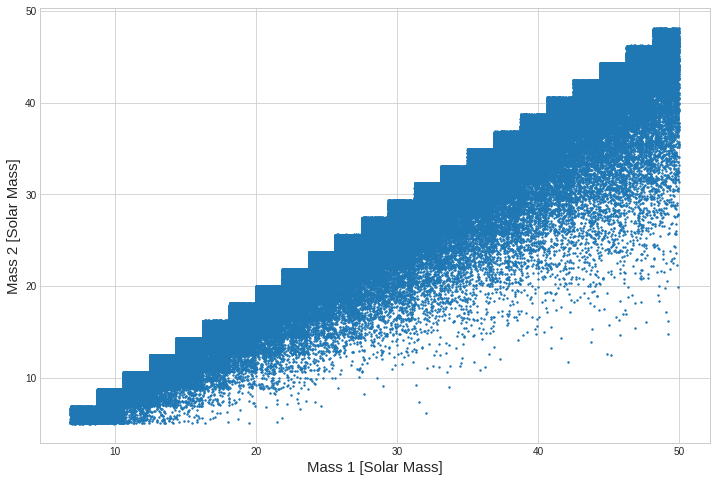

In [27]:
plt.figure(figsize=(12,8))
plt.scatter(df['Mass1'], df['Mass2'], s=2)
plt.xlabel('Mass 1 [Solar Mass]', fontsize = 15)
plt.ylabel('Mass 2 [Solar Mass]', fontsize = 15)
plt.savefig('MassesScatterplot.png',dpi=500)

Together with a scatter plot for the spin amplitude and orientation :


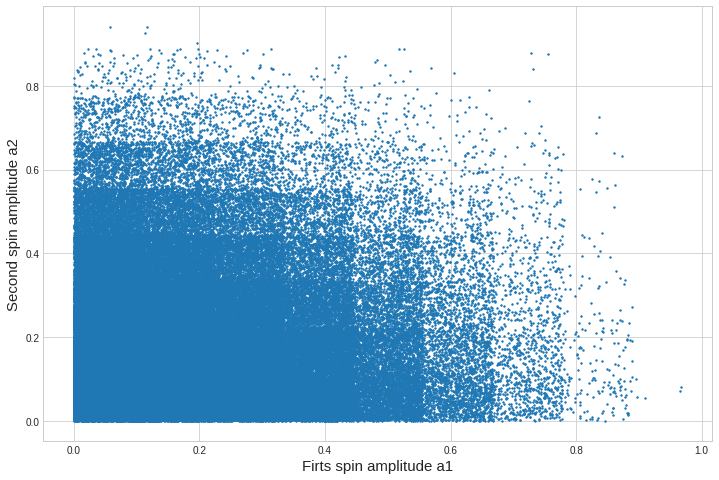

In [28]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['Spin1'], BHCat['Spin2'], s=2)
plt.xlabel('Firts spin amplitude a1', fontsize = 15)
plt.ylabel('Second spin amplitude a2', fontsize = 15)
plt.savefig('FrqHist.png',dpi=500)
plt.savefig('SpinAmplitudesScatterplot.png',dpi=500)

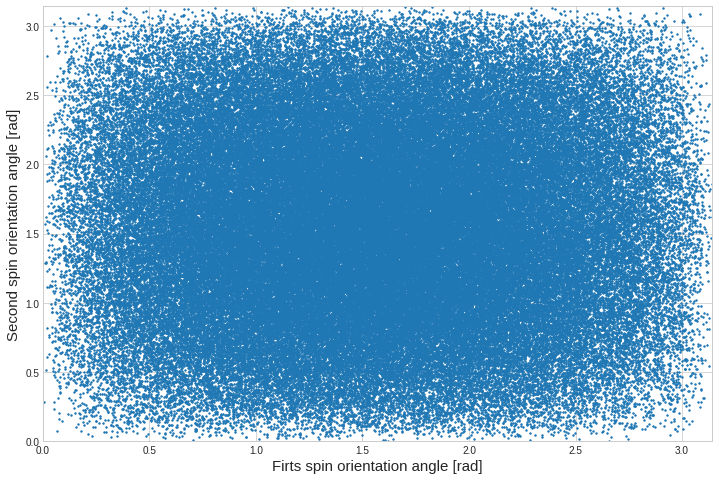

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(BHCat['AzimuthalAngleOfSpin1'], BHCat['AzimuthalAngleOfSpin2'], s=2)
plt.xlabel('Firts spin orientation angle [rad]', fontsize = 15)
plt.ylabel('Second spin orientation angle [rad]', fontsize = 15)
plt.xlim(0,np.pi)
plt.ylim(0,np.pi)
plt.savefig('SpinTiltsScatterplot.png',dpi=500)

Finally, the properties of the generated dataframe may be observed from an histogram of the frequencies :

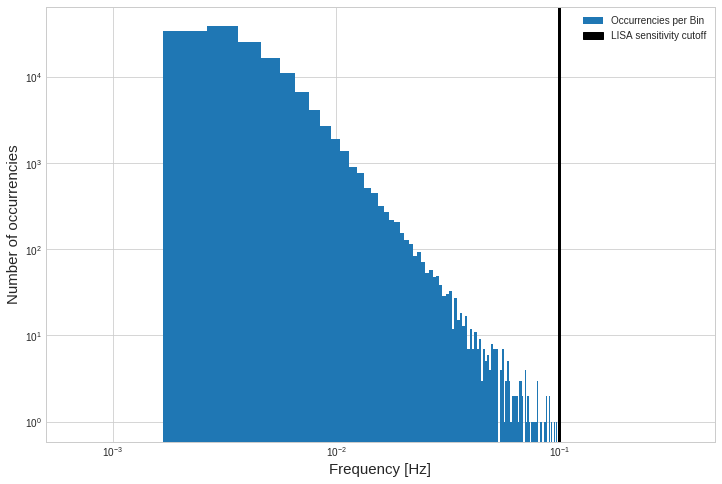

In [30]:
plt.figure(figsize=(12,8))
plt.hist(df['InitialFrequency'], bins = 100, label = 'Occurrencies per Bin')
plt.xlabel('Frequency [Hz]', fontsize = 15)
plt.xlim(5*10**(-4),5*10**(-1))
plt.xscale('log')
plt.yscale('log')
plt.axvspan(frq_max-0.001, frq_max + 0.001, 0, 1, color = 'black', label = 'LISA sensitivity cutoff')
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('FrqHist.png',dpi=500)

and an hystogram showing the time of each event inside the LISA band :

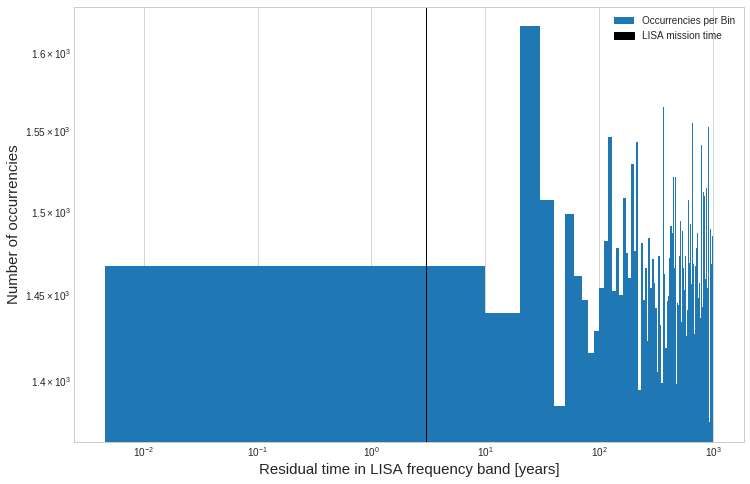

In [31]:
plt.figure(figsize=(12,8))
plt.hist(df['OutOfBandTime'], bins = 100, label = 'Occurrencies per Bin')
plt.xlabel('Residual time in LISA frequency band [years]', fontsize = 15 )
plt.xscale('log')
plt.yscale('log')
plt.axvspan(T_obs - 0.01, T_obs + 0.01, 0, 1, color = 'black', label = 'LISA mission time')
plt.legend(loc = 1)
plt.ylabel('Number of occurrencies', fontsize = 15)
plt.savefig('TimeInFrequencyBand.png',dpi=500)